In [1]:
# -*- coding: utf-8 -*-

import os
import pandas as pd
from datetime import datetime
from utils import news_crawler
from utils import news_pandas
from utils import preprocessing
from utils import modeling
from utils import drawing
from utils import counter
from collections import Counter

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# __file__ = r'/home/jacen/PycharmProjects/HotNewsAnalysis/main.ipynb'
__file__ = r'F:\jacen_documents\HotNewsAnalysis\main.ipynb'
# 获取项目路径
project_path = os.path.dirname(os.path.realpath(__file__))
# 获取数据存放目录路径
data_path = os.path.join(project_path, 'data')
fonts_path = os.path.join(data_path, 'fonts')
images_path = os.path.join(data_path, 'images')
texts_path = os.path.join(data_path, 'texts')
extra_dict_path = os.path.join(data_path, 'extra_dict')
models_path = os.path.join(data_path, 'models')
news_path = os.path.join(data_path, 'news')
temp_news_path = os.path.join(data_path, 'temp_news')
results_path = os.path.join(data_path, 'results')

In [3]:
sina_news_df = news_crawler.get_latest_news('sina', top=10, show_content=True)
sohu_news_df = news_crawler.get_latest_news('sohu', top=10, show_content=True)
xinhuanet_news_df = news_crawler.get_latest_news('xinhuanet', top=10, show_content=True)
news_pandas.save_news(sina_news_df, os.path.join(news_path, 'sina_latest_news.csv'))
news_pandas.save_news(sohu_news_df, os.path.join(news_path, 'sohu_latest_news.csv'))
news_pandas.save_news(xinhuanet_news_df, os.path.join(news_path, 'xinhuanet_latest_news.csv'))
news_crawler.threaded_crawler()

http://roll.news.sina.com.cn/interface/rollnews_ch_out_interface.php?col=43&spec=&type=&ch=03&k=&offset_page=0&offset_num=0&num=10&asc=&page=1&r=0.5186854397187665
http://v2.sohu.com/public-api/feed?scene=CHANNEL&sceneId=15&page=1&size=10
http://qc.wa.news.cn/nodeart/list?nid=11147664&pgnum=1&cnt=10&tp=1&orderby=1
http://roll.news.sina.com.cn/interface/rollnews_ch_out_interface.php?col=43&spec=&type=&ch=03&k=&offset_page=0&offset_num=0&num=10&asc=&page=1&r=0.4466616080181944http://v2.sohu.com/public-api/feed?scene=CHANNEL&sceneId=15&page=1&size=10

http://qc.wa.news.cn/nodeart/list?nid=11147664&pgnum=1&cnt=10&tp=1&orderby=1
sohu_news_df.shape= (10, 4)
xinhuanet_news_df.shape= (10, 4)
sina_news_df.shape= (10, 4)
爬取新闻完成！


In [4]:
# sina_news_df = news_pandas.load_news(os.path.join(news_path, 'sample_sina_latest_news.csv'))
# sohu_news_df = news_pandas.load_news(os.path.join(news_path, 'sample_sohu_latest_news.csv'))
# xinhuanet_news_df = news_pandas.load_news(os.path.join(news_path, 'sample_xinhuanet_latest_news.csv'))
news_df = pd.concat([sina_news_df, sohu_news_df, xinhuanet_news_df], ignore_index=True)
news_pandas.save_news(news_df, os.path.join(news_path, 'sample_news_df.csv'))

In [5]:
filter_df = preprocessing.data_filter(news_df)
news_pandas.save_news(filter_df, os.path.join(temp_news_path, 'filter_news.csv'))

In [6]:
print(filter_df.shape[0])

30


In [7]:
now_time = datetime.strftime(datetime.now(), '%Y-%m-%d %H:%M')
# now_time = '2018-04-06 23:59'
filter_df = preprocessing.get_data(filter_df, last_time=now_time, delta=5)
news_pandas.save_news(filter_df, os.path.join(temp_news_path, 'filter_news_by_time.csv'))
print(filter_df.shape[0])

df.shape= (30, 4)
30


# 按新闻内容聚类

In [8]:
df = filter_df.copy()
df['title_'] = df['title'].map(lambda x: preprocessing.clean_title_blank(x))
df['content_'] = df['content'].map(lambda x: preprocessing.clean_content(x))
df['content_'] = df['content_'].map(lambda x: preprocessing.get_num_en_ch(x))
df['content_cut'] = df['content_'].map(lambda x: preprocessing.pseg_cut(
    x, userdict_path=os.path.join(extra_dict_path, 'self_userdict.txt')))
df['content_cut'] = df['content_cut'].map(lambda x: preprocessing.get_words_by_flags(
    x, flags=['n.*', 'v.*', 'eng', 't', 's', 'j', 'l', 'i']))
df['content_cut'] = df['content_cut'].map(lambda x: preprocessing.stop_words_cut(
    x, os.path.join(extra_dict_path, 'self_stop_words.txt')))
df['content_cut'] = df['content_cut'].map(lambda x: preprocessing.disambiguation_cut(
    x, os.path.join(extra_dict_path, 'self_disambiguation_dict.json')))
df['content_cut'] = df['content_cut'].map(lambda x: preprocessing.individual_character_cut(
    x, os.path.join(extra_dict_path, 'self_individual_character_dict.txt')))
df['content_'] = df['content_cut'].map(lambda x: ' '.join(x))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.623 seconds.
Prefix dict has been built succesfully.


In [9]:
news_pandas.save_news(df, os.path.join(temp_news_path, 'news_cut.csv'))

In [10]:
df = news_pandas.load_news(os.path.join(temp_news_path, 'news_cut.csv'))
df['content_cut'] = df['content_cut'].map(eval)
df['content_'] = df['content_'].map(str)

In [11]:
df[:2]

,title,time,url,content,title_,content_,content_cut
0,财经观察：委内瑞拉货币改革能否稳定经济,2018-08-22 09:29,http://www.xinhuanet.com/fortune/2018-08/21/c_...,新华社加拉加斯８月２１日电 财经观察：委内瑞拉货币改革能否稳定经济\n 新华社记者徐烨...,财经观察：委内瑞拉货币改革能否稳定经济,加拉加斯 日电 观察 委内瑞拉 货币 改革 能否 徐烨 王瑛 委内瑞拉 开启 货币 改革 原...,"[加拉加斯, 日电, 观察, 委内瑞拉, 货币, 改革, 能否, 徐烨, 王瑛, 委内瑞拉,..."
1,美图被抛弃：用户流失27％ 营收下滑6% 股价跌60%,2018-08-22 09:28,http://finance.sina.com.cn/zl/2018-08-22/zl-ih...,在接近一年半的时间里，美图面临着前所未有之困境：美图的营收下降、亏损基本无改善、月活用户...,美图被抛弃：用户流失27％ 营收下滑6% 股价跌60%,接近 时间 美国 面临 前所未有 困境 美图 营收 亏损 基本 改善 用户 主力 下滑 股价...,"[接近, 时间, 美国, 面临, 前所未有, 困境, 美图, 营收, 亏损, 基本, 改善,..."


In [12]:
word_library_list = counter.get_word_library(df['content_cut'])
word_library = '\n'.join(word_library_list)
news_pandas.save_text(word_library, os.path.join(texts_path, 'word_library.txt'))

In [13]:
single_frequency_words_list = counter.get_single_frequency_words(df['content_cut'])

In [14]:
max_features = len(word_library_list) - len(single_frequency_words_list) // 2
print(len(word_library_list), len(single_frequency_words_list), max_features)

3182 1756 2304


In [15]:
matrix = modeling.feature_extraction(df['content_'], vectorizer='CountVectorizer',
                                             vec_args={'max_df': 0.95, 'min_df': 1, 'max_features': max_features})
matrix.shape

(30, 2304)

In [16]:
for i in range(1, 100):
    dbscan = modeling.get_cluster(matrix, cluster='DBSCAN',
                                      cluster_args={'eps': i/100, 'min_samples': 5, 'metric': 'cosine'})
    labels = modeling.get_labels(dbscan)
    print(i, ':', counter.get_num_of_value_no_repeat(labels), end=' ')

1 : 1 2 : 1 3 : 1 4 : 1 5 : 1 6 : 1 7 : 1 8 : 1 9 : 1 10 : 1 11 : 1 12 : 1 13 : 1 14 : 1 15 : 1 16 : 1 17 : 1 18 : 1 19 : 1 20 : 1 21 : 1 22 : 1 23 : 1 24 : 1 25 : 1 26 : 1 27 : 1 28 : 1 29 : 1 30 : 1 31 : 1 32 : 1 33 : 1 34 : 1 35 : 1 36 : 1 37 : 1 38 : 1 39 : 1 40 : 1 41 : 1 42 : 1 43 : 1 44 : 1 45 : 1 46 : 1 47 : 1 48 : 1 49 : 1 50 : 1 51 : 1 52 : 1 53 : 1 54 : 1 55 : 1 56 : 1 57 : 1 58 : 1 59 : 1 60 : 1 61 : 1 62 : 1 63 : 1 64 : 1 65 : 1 66 : 1 67 : 1 68 : 1 69 : 1 70 : 1 71 : 1 72 : 1 73 : 1 74 : 1 75 : 1 76 : 1 77 : 1 78 : 1 79 : 1 80 : 1 81 : 1 82 : 1 83 : 2 84 : 2 85 : 3 86 : 3 87 : 3 88 : 4 89 : 3 90 : 2 91 : 2 92 : 2 93 : 2 94 : 2 95 : 2 96 : 1 97 : 1 98 : 1 99 : 1 

In [17]:
dbscan = modeling.get_cluster(matrix, cluster='DBSCAN',
                                      cluster_args={'eps': 0.89, 'min_samples': 2, 'metric': 'cosine'})

In [18]:
labels = modeling.get_labels(dbscan)
df['label'] = labels
ranks = modeling.label2rank(labels)
df['rank'] = ranks

In [19]:
news_pandas.save_news(df, os.path.join(temp_news_path, 'news_label.csv'))

In [20]:
df = news_pandas.load_news(os.path.join(temp_news_path, 'news_label.csv'))
df['content_cut'] = df['content_cut'].map(eval)
df['content_'] = df['content_'].map(str)

In [21]:
df[:2]

,title,time,url,content,title_,content_,content_cut,label,rank
0,财经观察：委内瑞拉货币改革能否稳定经济,2018-08-22 09:29,http://www.xinhuanet.com/fortune/2018-08/21/c_...,新华社加拉加斯８月２１日电 财经观察：委内瑞拉货币改革能否稳定经济\n 新华社记者徐烨...,财经观察：委内瑞拉货币改革能否稳定经济,加拉加斯 日电 观察 委内瑞拉 货币 改革 能否 徐烨 王瑛 委内瑞拉 开启 货币 改革 原...,"[加拉加斯, 日电, 观察, 委内瑞拉, 货币, 改革, 能否, 徐烨, 王瑛, 委内瑞拉,...",0,1
1,美图被抛弃：用户流失27％ 营收下滑6% 股价跌60%,2018-08-22 09:28,http://finance.sina.com.cn/zl/2018-08-22/zl-ih...,在接近一年半的时间里，美图面临着前所未有之困境：美图的营收下降、亏损基本无改善、月活用户...,美图被抛弃：用户流失27％ 营收下滑6% 股价跌60%,接近 时间 美国 面临 前所未有 困境 美图 营收 亏损 基本 改善 用户 主力 下滑 股价...,"[接近, 时间, 美国, 面临, 前所未有, 困境, 美图, 营收, 亏损, 基本, 改善,...",0,1


In [22]:
df_non_outliers = df[df['label']!=-1].copy()

In [23]:
news_pandas.save_news(df_non_outliers, os.path.join(temp_news_path, 'news_non_outliers.csv'))

In [24]:
df_non_outliers = news_pandas.load_news(os.path.join(temp_news_path, 'news_non_outliers.csv'))
df_non_outliers['content_cut'] = df_non_outliers['content_cut'].map(eval)
df_non_outliers['content_'] = df_non_outliers['content_'].map(str)

In [25]:
df_non_outliers[:2]

,title,time,url,content,title_,content_,content_cut,label,rank
0,财经观察：委内瑞拉货币改革能否稳定经济,2018-08-22 09:29,http://www.xinhuanet.com/fortune/2018-08/21/c_...,新华社加拉加斯８月２１日电 财经观察：委内瑞拉货币改革能否稳定经济\n 新华社记者徐烨...,财经观察：委内瑞拉货币改革能否稳定经济,加拉加斯 日电 观察 委内瑞拉 货币 改革 能否 徐烨 王瑛 委内瑞拉 开启 货币 改革 原...,"[加拉加斯, 日电, 观察, 委内瑞拉, 货币, 改革, 能否, 徐烨, 王瑛, 委内瑞拉,...",0,1
1,美图被抛弃：用户流失27％ 营收下滑6% 股价跌60%,2018-08-22 09:28,http://finance.sina.com.cn/zl/2018-08-22/zl-ih...,在接近一年半的时间里，美图面临着前所未有之困境：美图的营收下降、亏损基本无改善、月活用户...,美图被抛弃：用户流失27％ 营收下滑6% 股价跌60%,接近 时间 美国 面临 前所未有 困境 美图 营收 亏损 基本 改善 用户 主力 下滑 股价...,"[接近, 时间, 美国, 面临, 前所未有, 困境, 美图, 营收, 亏损, 基本, 改善,...",0,1


In [26]:
rank_num = counter.get_num_of_value_no_repeat(df_non_outliers['rank'])
rank_num

1

In [27]:
df_rank_i = df_non_outliers[df_non_outliers['rank'] == 1]
top_words_list = counter.get_most_common_words(df_rank_i['content_cut'], top_n=15, min_frequency=1)
all_title = '\n'.join(df_rank_i['title_'].tolist())
key_title = modeling.get_key_sentences(all_title, num=1)
# print(df_rank_i)
print(top_words_list)
print(key_title)

['城市', '美国', '回购', '投资', '上市公司', '特朗普', '租赁', '中国', '股份', '股东', '关税', '智慧', '民间', '服务', '上海']
A股公司年内拟回购额达662亿元 机构：A股处于第五轮“牛熊”周期底部


In [28]:
data_pca_tsne = modeling.feature_reduction(matrix.toarray(), pca_n_components=50, tsne_n_components=2)

data_pca_tsne.shape= (30, 2)


In [29]:
df['pca_tsne'] = data_pca_tsne.tolist()
df_non_outliers = df[df['label']!=-1].copy()

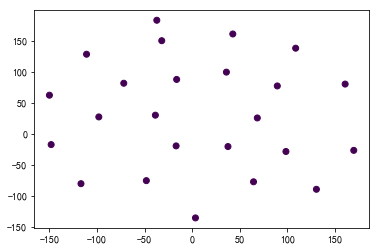

In [30]:
drawing.draw_clustering_result(df_non_outliers['pca_tsne'], df_non_outliers['label'])

In [31]:
rank_num = counter.get_num_of_value_no_repeat(df_non_outliers['rank'])
value = [df_non_outliers[df_non_outliers['rank'] == i].shape[0] for i in range(1, rank_num+1)]
yticks1 = [counter.get_most_common_words(df_non_outliers[df_non_outliers['rank'] == i]['content_cut'], top_n=15) for i in range(1, rank_num+1)]
yticks2 = [modeling.get_key_sentences('\n'.join(df_non_outliers[df_non_outliers['rank'] == i]['title_']), num=1) for i in range(1, rank_num+1)]
print(rank_num)
print(value)
print(yticks1)

1
[24]
[['城市', '美国', '回购', '投资', '上市公司', '特朗普', '租赁', '中国', '股份', '股东', '关税', '智慧', '民间', '服务', '上海']]


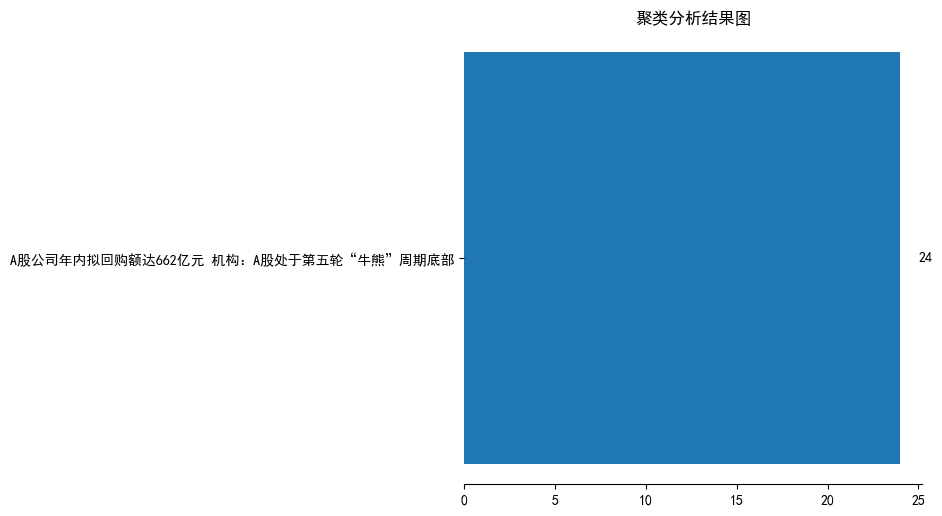

In [32]:
drawing.draw_clustering_analysis_barh(rank_num, value, yticks2, title='聚类分析结果图')

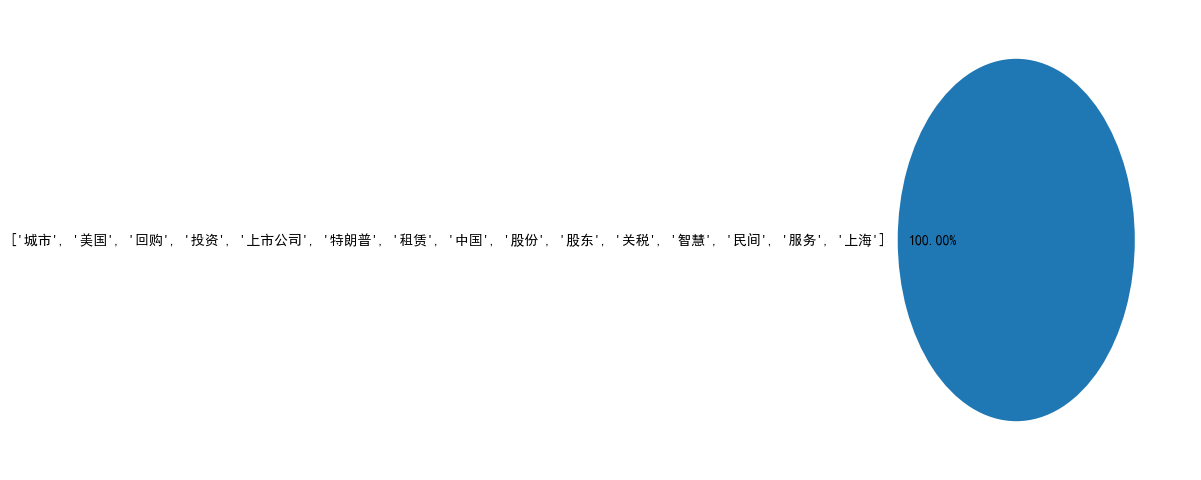

In [33]:
drawing.draw_clustering_analysis_pie(rank_num, value, yticks1)
# import matplotlib
# import matplotlib.pyplot as plt
# plt.pie(value, explode=[i/15 for i in range(1, rank_num+1)], labels=yticks, autopct='%1.2f%%', pctdistance=0.8, labeldistance=1.5)

In [34]:
document = '\n'.join([str(content) for content in news_df['content']])
preprocessing.document2txt(document, userdict_path=os.path.join(extra_dict_path, 'self_userdict.txt'),
                          text_path=os.path.join(texts_path, 'document_segment.txt'))

In [35]:
model = modeling.get_word2vec_model(text_path=os.path.join(texts_path, 'document_segment.txt'))

In [36]:
news_pandas.save_element(model, os.path.join(models_path, 'word2vec_model.pkl'))

In [37]:
model = news_pandas.load_element(os.path.join(models_path, 'word2vec_model.pkl'))

In [38]:
model.wv.most_similar('中国')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('行业', 0.9994689226150513),
 ('不', 0.9994410872459412),
 ('其', 0.9994062185287476),
 ('目前', 0.9993559122085571),
 ('转让', 0.9992219805717468),
 ('产业', 0.9991381168365479),
 ('消息', 0.9991260766983032),
 ('证券', 0.9990135431289673),
 ('有', 0.9990097284317017),
 ('手续费', 0.9989175796508789)]

In [39]:
df_rank_i = df_non_outliers[df_non_outliers['rank'] == 1]
top_words_list = counter.get_most_common_words(df_rank_i['content_cut'], top_n=5000, min_frequency=1)

In [40]:
word_list, wordvec_list = modeling.get_word_and_wordvec(model, top_words_list)

In [41]:
import numpy as np
wordvec_list=np.array(wordvec_list)
wordvec_list=wordvec_list.tolist()

In [42]:
kmeans = modeling.get_cluster(wordvec_list, cluster='KMeans', cluster_args={'n_clusters': 20, 'random_state': 9})

In [43]:
word_label = kmeans.labels_
counter.get_num_of_value_no_repeat(word_label)

20

In [44]:
# modeling.get_top_words(word_list, word_label, label_num=20)

In [45]:
word_pca_tsne = modeling.feature_reduction(wordvec_list, pca_n_components=2, tsne_n_components=None)

data_pca_tsne.shape= (2770, 2)


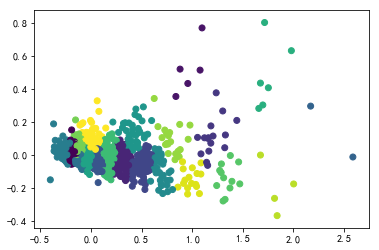

In [46]:
drawing.draw_clustering_result(word_pca_tsne, word_label)

In [47]:
import pandas as pd

In [48]:
word_df = pd.DataFrame()
word_df['word'] = word_list
word_df['wordvec'] = wordvec_list
word_df['word_label'] = word_label

In [49]:
word_df[:10]

,word,wordvec,word_label
0,城市,"[-0.021063538268208504, 0.1655557006597519, 0....",12
1,美国,"[0.10517068952322006, 0.13794240355491638, 0.2...",6
2,回购,"[0.011099453084170818, 0.12111087888479233, 0....",12
3,投资,"[0.033360447734594345, 0.14572732150554657, 0....",12
4,上市公司,"[0.06409438699483871, 0.13815023005008698, 0.1...",6
5,特朗普,"[0.029291117563843727, 0.11776310205459595, 0....",12
6,租赁,"[0.06711161881685257, 0.09820456057786942, 0.2...",17
7,中国,"[0.10410020500421524, 0.11204037070274353, 0.2...",17
8,股份,"[-0.0018634699517861009, 0.08594159036874771, ...",1
9,股东,"[0.06419394165277481, 0.09299473464488983, 0.2...",14


In [50]:
word_label_value = [word_df[word_df['word_label']==i].shape[0] for i in range(20)]
word_label_yticks = [word_df[word_df['word_label']==i]['word'][:10].tolist() for i in range(20)]
word_label_yticks

[['特征', '强调', '效率', '当下', '法律', '促进', '主营业务', '黄河', '回落', '马杜罗'],
 ['股份', '智慧', '增速', '控股', '机构'],
 ['当前', '房源', '配租', '战略', '信心', '价格', '世纪', '社会', '应届', '乐视'],
 ['民间', '服务', '改革', '资金', '建设', '美联储', '时间', '未来', '金融', '投资者'],
 ['增加', '阶段', '程度', '发布', '鲍威尔', '听证会', '水平', '供给', '研究院', '过程'],
 ['作用', '缓解', '效应', '伴随', '利率', '备案', '国有企业', '玻利瓦尔', '累计', '标的'],
 ['美国', '上市公司'],
 ['授意', '如今', '净资产', '比例', '出口', '何代欣', '经验', '规范', '穆勒', '态度'],
 ['二当家', '交通', '主权', '贸易战', '领跑', '比重', '教育', '逻辑', '规范化', '签署'],
 ['总统', '祥源', '登记', '国内', '方式', '加息', '养老院', '进入', '形成', '协议'],
 ['北京', '房租', '估值', '分析', '重点', '价值', '公布', '整体', '养老', '加征'],
 ['迎来', '荀玉根', '志愿', '资料', '修复', '支撑', '生态', '短板', '低位', '角度'],
 ['城市', '回购', '投资', '特朗普', '汽车', '车险'],
 ['近期', '关系', '非上市', '情绪', '模式', '改善', '体现', '租金', '后期', '委内瑞拉'],
 ['股东', '上海', '股权', '住房', '交易', '项目', '集体', '转让', '政府', '主席'],
 ['房价', '注意', '活力', '半年报', '高质量', '产业结构', '报告', '分众传媒', '财报', '高精尖'],
 ['领域', '上半年', '深圳', '乐视网', '全国', '超过', '体系', '计划', '成为', '贸易'

In [51]:
word_df[word_df['word_label']==11]['word'][:20]

205     迎来
254    荀玉根
265     志愿
281     资料
298     修复
299     支撑
310     生态
367     短板
379     低位
387     角度
388     值得
396     方向
397     汇川
425     恒大
440     营收
443     营业
446     行动
459     开盘
463     中期
466     解套
Name: word, dtype: object

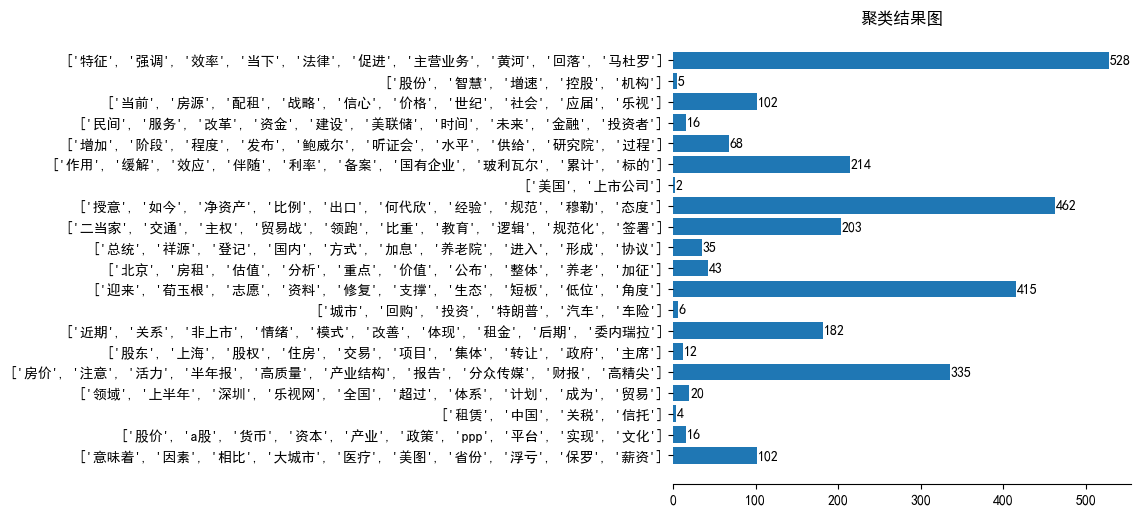

In [52]:
drawing.draw_clustering_analysis_barh(20, word_label_value, word_label_yticks, title='聚类结果图')

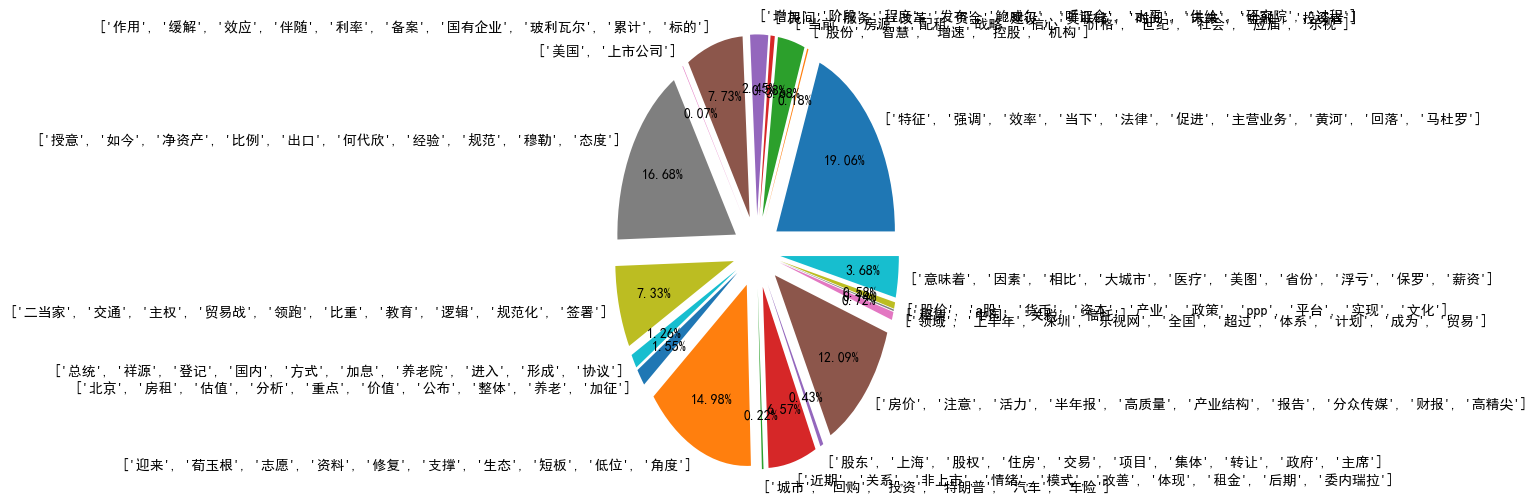

In [53]:
drawing.draw_clustering_analysis_pie(20, word_label_value, word_label_yticks)